# **Installing dataset from Kaggle API**

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nishantsingh96
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140


100%|██████████| 80.9M/80.9M [00:00<00:00, 569MB/s]

# **Importing necessary libraries**

In [3]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from google.colab import drive
drive.mount('/content/drive')
import os
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

Mounted at /content/drive


# **Initializing Dataset 'Tweet Sentiment Analysis'**

In [4]:
Data=pd.read_csv(r'/content/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)
Data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
Data.columns=['Target',"ID",'Date','Query?','Names','Text']
Data.head()

,Target,ID,Date,Query?,Names,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# **Drop Down Unusual features**

In [6]:
Data=Data.drop(["ID",'Date','Query?','Names'],axis=1)
Data.head()

,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# **Checking for high length Sentences (Outliers) in Data['Text']**

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
def findLength(text):
    text=text.split(' ')
    return len(text)

Len=list(map(findLength,Data['Text']))

Text(0.5, 1.0, "BoxPlot of Text's length")

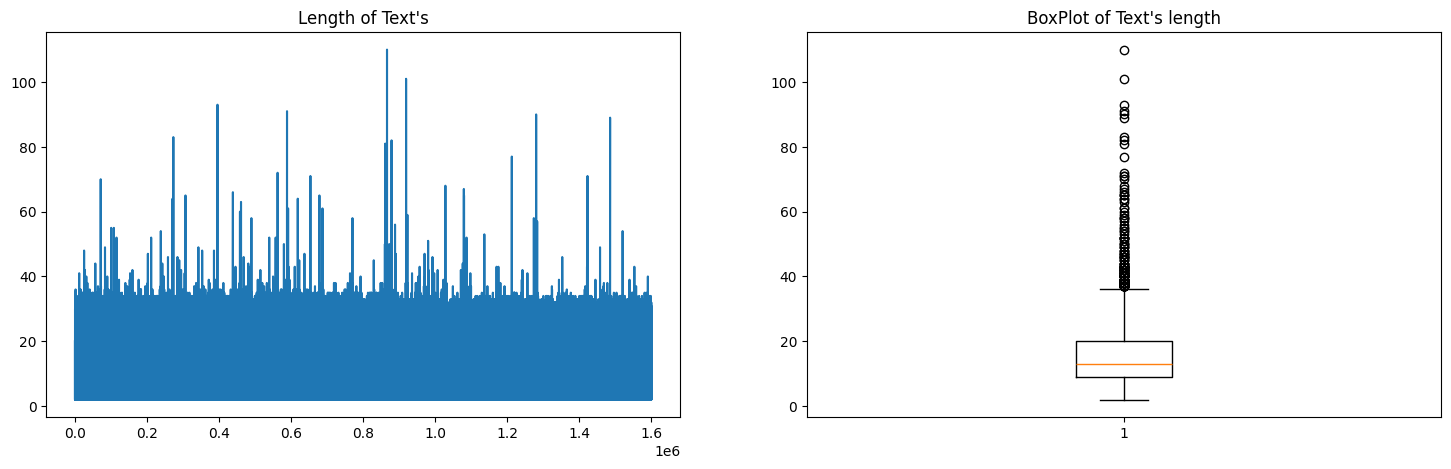

In [9]:
fig,axes=plt.subplots(1,2,figsize=(18,5))

axes[0].plot(Len)
axes[0].set_title("Length of Text's")
axes[1].boxplot(Len)
axes[1].set_title("BoxPlot of Text's length")

# **Removing that outliers to make length persistant and small**

In [10]:
Data=Data[Data['Text'].apply(lambda x: len(x.split(' ')) <= 38)]
print('Length of final Filtered Dataset:',len(Data),f'| Outliers {len(Data)-1599999} Removed!')
Data.head()

Length of final Filtered Dataset: 1599873 | Outliers -126 Removed!


,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [11]:
def clean_tweet(text):
    text=re.sub(r'http\S+', '', text)
    text=re.sub(r'@\w+', '', text)
    text=re.sub(r'#', '', text)
    text=re.sub(r'\s+', ' ', text)
    return text.strip()

Data['Text']=Data['Text'].apply(clean_tweet)

In [12]:
Data.head()

,Target,Text
0,0,"- Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


# **Using pretrained model 'all-MiniLM-L6-v2' for encoding of texts**

it converts every sentence to a fixed 384 numeric vector

In [13]:
Model=SentenceTransformer('all-MiniLM-L6-v2')

def batch_encode(sentences, batch_size=128):
    embeddings=[]
    for i in range(0, len(sentences), batch_size):
        batch=sentences[i:i+batch_size]
        batch_embeddings=Model.encode(batch,show_progress_bar=True)
        embeddings.append(batch_embeddings)
        print(i+batch_size,'Done!')
    return np.vstack(embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
embeddings=batch_encode(Data['Text'][:5000].to_list(), batch_size=512)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

512 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

1024 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

1536 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2048 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2560 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

3072 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

3584 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

4096 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

4608 Done!


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

5120 Done!


In [15]:
print('Shape of Output Embedding:',embeddings.shape)
print('Type of Embeddings:',type(embeddings))

Shape of Output Embedding: (5000, 384)
Type of Embeddings: <class 'numpy.ndarray'>


# **Continue with K-Means Clusterings**

In [16]:
num_clusters=2
kmeans=KMeans(n_clusters=num_clusters, random_state=42)
labels=kmeans.fit_predict(embeddings)

In [17]:
score=silhouette_score(embeddings, labels)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.02


In [18]:
pca=PCA(n_components=2)
reduced=pca.fit_transform(embeddings)

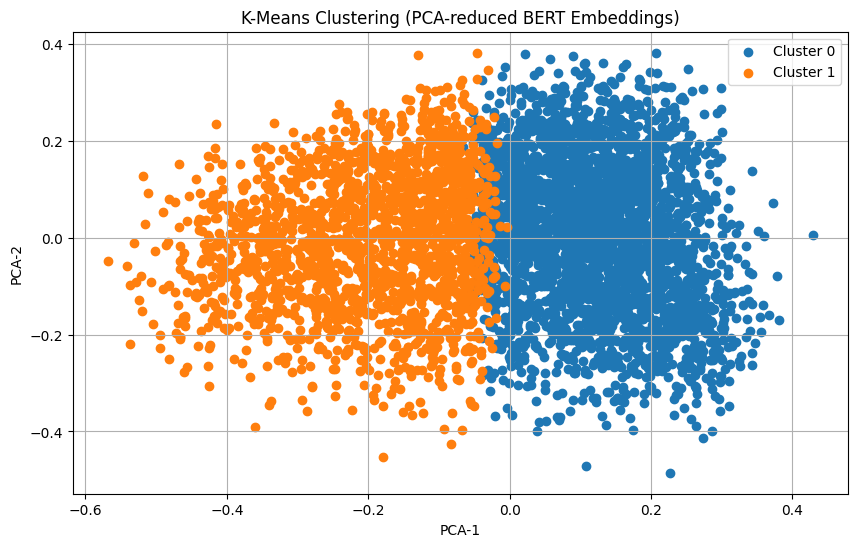

In [19]:
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    points=reduced[labels==i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')

plt.title("K-Means Clustering (PCA-reduced BERT Embeddings)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend()
plt.grid(True)
plt.show()

# **Continue with DBSCAN**

In [20]:
dbscan=DBSCAN(eps=1.2, min_samples=5, metric='cosine')  # adjust eps as needed
labels=dbscan.fit_predict(embeddings)

In [21]:
n_clusters=len(set(labels)) - (1 if -1 in labels else 0)
print(f"Estimated clusters: {n_clusters}")
print(f"Noise points: {(labels == -1).sum()}")

# Step 3: Visualize with PCA
pca=PCA(n_components=2)
reduced=pca.fit_transform(embeddings)

Estimated clusters: 1
Noise points: 0


/tmp/ipython-input-22-430851901.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=plt.cm.get_cmap('tab10', len(unique_labels))


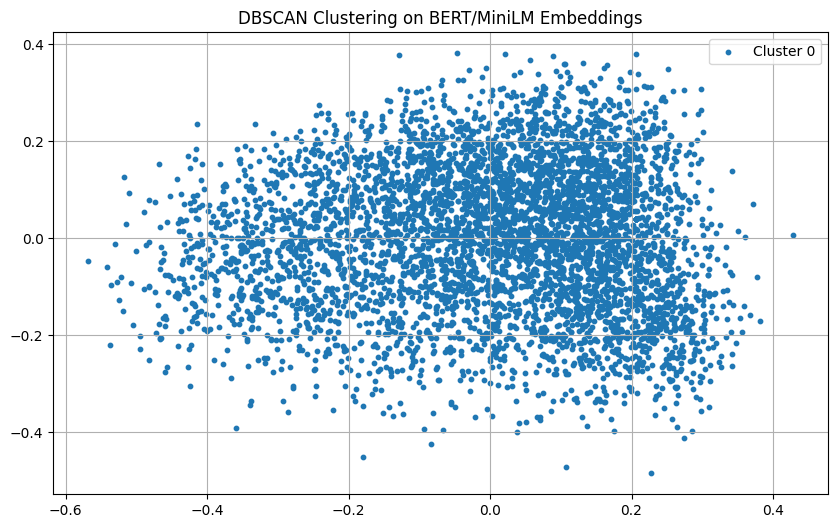

In [22]:
plt.figure(figsize=(10, 6))
unique_labels=set(labels)
colors=plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    if label == -1:
        color='gray'  # noise
        label_name='Noise'
    else:
        color=colors(label)
        label_name=f'Cluster {label}'
    plt.scatter(
        reduced[labels==label, 0],
        reduced[labels==label, 1],
        s=10,
        label=label_name,
        color=color
    )

plt.title("DBSCAN Clustering on BERT/MiniLM Embeddings")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
Data['Target'].value_counts()

,count
Target,
4,799946
0,799927


# **Implementing Deep Learning To make predictions robust**

**Preparing Dataset**

In [32]:
X=list(Data['Text'][-2500:])+list(Data['Text'][:2500])
y=pd.concat([Data['Target'][-2500:].replace({4:1}),Data['Target'][:2500]])

In [38]:
X=batch_encode(X, batch_size=512)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

512 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

1024 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

1536 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2048 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2560 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

3072 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

3584 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

4096 Done!


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

4608 Done!


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

5120 Done!


In [33]:
y.value_counts()

,count
Target,
1,2500
0,2500


In [39]:
X.shape

(5000, 384)

**Designing Architecture**

In [40]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.LayerNormalization(epsilon=1e-6),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [41]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [42]:
model.fit(X,y,epochs=10,batch_size=32)

Epoch 1/10
157/157 [==============================] - 3s 3ms/step - loss: 0.5590 - accuracy: 0.7138
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.7920
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 0.3806 - accuracy: 0.8272
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 0.3085 - accuracy: 0.8676
Epoch 5/10
157/157 [==============================] - 0s 3ms/step - loss: 0.2375 - accuracy: 0.9042
Epoch 6/10
157/157 [==============================] - 0s 3ms/step - loss: 0.1835 - accuracy: 0.9266
Epoch 7/10
157/157 [==============================] - 0s 3ms/step - loss: 0.1258 - accuracy: 0.9530
Epoch 8/10
157/157 [==============================] - 0s 3ms/step - loss: 0.1007 - accuracy: 0.9608
Epoch 9/10
157/157 [==============================] - 0s 3ms/step - loss: 0.0726 - accuracy: 0.9764
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.9752